# Workshop Tutorial: MCMC basics with PHOEBE

In this tutorial we will continue our investigation of the synthesized EB data that we used to [estimate parameters](./Tutorial_08a_estimators.ipynb) and to [optimize them using NMS](./Tutorial_08b_optimizers.ipynb). We have *a* solution at hand, now we need to sample the parameter space in order to understand its topology and take steps towards heuristic uncertainties for our parameters.

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorial(s):

* [Advanced: EMCEE Sampler](http://phoebe-project.org/docs/2.3/tutorials/emcee.ipynb)


Let's start by the usual imports:

In [1]:
import phoebe
import numpy as np

Matplotlib's and numpy's deprecation warnings are quite... verbose, so we will turn them off until we've had the chance to address them properly:

In [2]:
# logger = phoebe.logger()
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Now let's pick up where we left off: load the [bundle that contains optimization results](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/after_optimizers.bundle):

In [3]:
b = phoebe.load('./data/synthetic/after_optimizers.bundle')

To remind ourselves, let's plot the phased light and RV curves, along with all the models that are stored in the bundle:

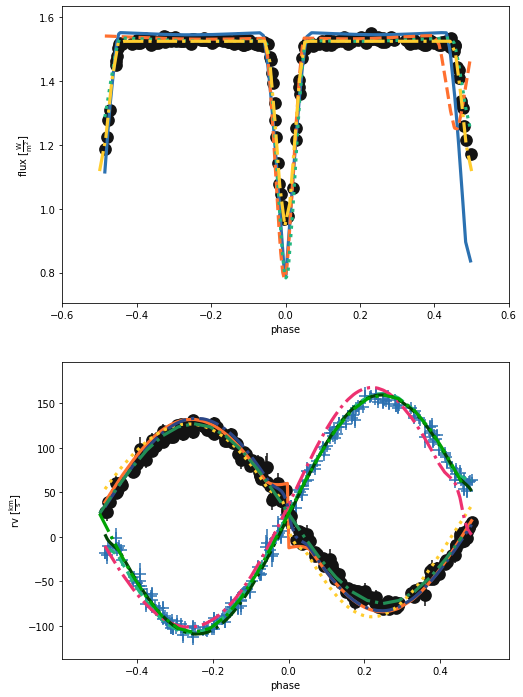

(<autofig.figure.Figure | 2 axes | 15 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [4]:
b.plot(x='phase', show=True)

We are curious to see which models there are; phoebe keeps them all labeled, and we can get a list by issuing:

In [5]:
b.models

['rvgeom_model', 'ebai_model', 'lcgeom_model', 'latest']

Similarly, we can take a look at what compute options have been defined:

In [6]:
b.computes

['phoebe01', 'nm_fit']

Instead of overwriting any of them, we will create a new one for the MCMC run. Sampling a parameter space is an expensive task in terms of processing power and wall time, so for the purposes of this tutorial we will limit ourselves to the simplest possible model. We will disable the light curve and fit dynamical (i.e., point-mass) radial velocity curves to RV data. In a [later tutorial](./Tutorial_11_mcmc_continued.ipynb) we will explain how to farm out the computation to a computer cluster.

So let's get going; let's initialize a new compute option, disable the LC and change the RV function from flux-weighted to dynamical:

In [7]:
b.add_compute(compute='dyn_rv')
b['enabled@lc01@dyn_rv'] = False
b['rv_method@primary@dyn_rv'] = 'dynamical'
b['rv_method@secondary@dyn_rv'] = 'dynamical'
b['irrad_method@dyn_rv'] = 'none'

Take a quick look to see if we are happy with all compute options:

In [8]:
print(b['dyn_rv'])

ParameterSet: 22 parameters
       sample_from@dyn_rv@compute: []
          comments@dyn_rv@compute: 
        use_server@dyn_rv@compute: none
   dynamics_method@dyn_rv@compute: keplerian
              ltte@dyn_rv@compute: False
      irrad_method@dyn_rv@compute: none
   boosting_method@dyn_rv@compute: none
    eclipse_method@dyn_rv@compute: native
    horizon_method@dyn_rv@compute: boolean
      enabled@lc01@dyn_rv@compute: False
      enabled@rv01@dyn_rv@compute: True
   mesh_method@primary@dyn_rv@...: marching
   mesh_method@secondary@dyn_r...: marching
   ntriangles@primary@dyn_rv@c...: 1500
   ntriangles@secondary@dyn_rv...: 1500
   distortion_method@primary@d...: roche
   distortion_method@secondary...: roche
       atm@primary@dyn_rv@compute: ck2004
     atm@secondary@dyn_rv@compute: ck2004
        fti_method@dyn_rv@compute: none
   rv_method@primary@dyn_rv@co...: dynamical
   rv_method@secondary@dyn_rv@...: dynamical


We can now put these compute options to work! The parameters that influence RV curves are the projected semi-major axis `asini`, mass ratio `q`, barycentric velocity `vgamma`, eccentricity `ecc` and argument of periastron `per0`. Their face values are:

In [9]:
print(
    f" asini:  {b['value@asini@binary']}\n",
    f"q:      {b['value@q@orbit']}\n",
    f"vgamma: {b['value@vgamma@system']}\n",
    f"ecc:    {b['value@ecc@orbit']}\n",
    f"per0:   {b['value@per0@orbit']}")

 asini:  7.733947797809632
 q:      0.7562776815700893
 vgamma: 26.055544748401715
 ecc:    0.0
 per0:   90.3431416538605


Let's create an N-dimensional gaussian distribution (ndg) around the optimized values, draw a given number of combinations and calculate the models for them:

In [10]:
b.add_distribution({
    'asini@orbit': phoebe.gaussian_around(0.5),
    'q@binary': phoebe.gaussian_around(0.1),
    'vgamma@system': phoebe.gaussian_around(5.0),
    'ecc@orbit': phoebe.gaussian_around(0.05),
    'per0@orbit': phoebe.gaussian_around(10.0)
}, distribution='ndg', overwrite_all=True)

<ParameterSet: 5 parameters | qualifiers: asini, q, per0, ecc, vgamma>

Now we can run `run_compute()` by sampling from this distribution for, say, 50 samples:

In [11]:
b.run_compute(compute='dyn_rv', sample_from='ndg', sample_num=50, model='from_ndg', overwrite=True)

100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


<ParameterSet: 10 parameters | components: primary, secondary>

We can now take a look at the spread of models computed by using parameters drawn from this N-dimensional gaussian:

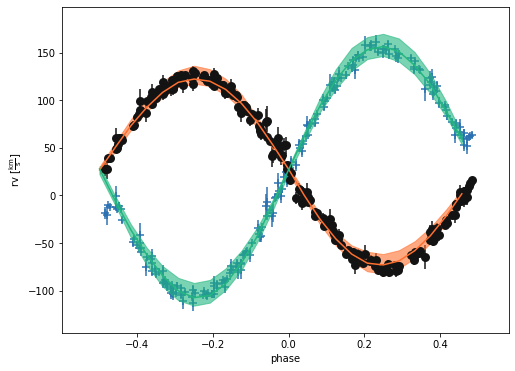

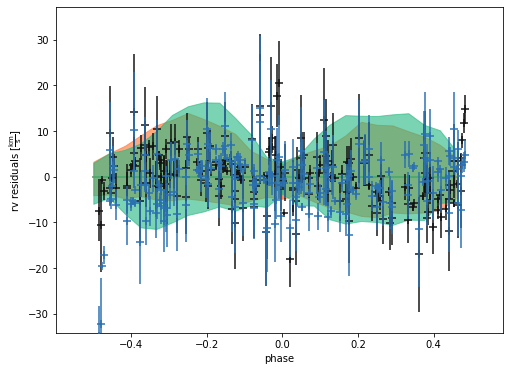

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [12]:
b.plot(model='from_ndg', x='phase', show=True)
b.plot(model='from_ndg', x='phase', y='residuals', show=True)

The spread looks good, so now we can proceed with adding a sampler. We do that in much the same way as we did for the estimators and optimizers, by running `b.add_solver()`. We will pass our newly initialized compute option-set to it so that the sampler knows what options to use, and our N-dimensional gaussian distribution so that the sampler initializes its starting points from it:

In [13]:
b.add_solver('sampler.emcee', solver='mcmc', compute='dyn_rv', init_from='ndg')

<ParameterSet: 16 parameters | qualifiers: comments, init_from_requires, priors_combine, continue_from, nlags_factor, use_server, compute, init_from_combine, thin_factor, nwalkers, progress_every_niters, init_from, priors, burnin_factor, niters, expose_failed>

Let's take a closer look at the sampler options; we will print them here and discuss them while the sampler is running.

In [14]:
print(b['mcmc'])

ParameterSet: 15 parameters
             comments@mcmc@solver: 
           use_server@mcmc@solver: compute
              compute@mcmc@solver: dyn_rv
        continue_from@mcmc@solver: None
            init_from@mcmc@solver: ['ndg']
    init_from_combine@mcmc@solver: first
   init_from_requires@mcmc@solver: ['limits', 'priors']
               priors@mcmc@solver: []
             nwalkers@mcmc@solver: 16
               niters@mcmc@solver: 100
        burnin_factor@mcmc@solver: 2.0
          thin_factor@mcmc@solver: 0.5
         nlags_factor@mcmc@solver: 3.0
   progress_every_niters@mcmc@...: 0
        expose_failed@mcmc@solver: True


These parameters drive the sampler, so let's review them here:

**comments**: provides a human-friendly description of the sampler options;

**use_server**: an external server to use for sampling;

**compute**: label for the compute options to be used by the sampler. If not provided, it uses the first compute option-set in `b.computes`;

**continue_from**: state of the sampler to continue from, we will address this in [the next tutorial](./Tutorial_11_mcmc_continued.ipynb).

**init_from**: a set of parameter distributions from which initial samples will be drawn, we are using our N-dimensional gaussian distribution for this;

**init_from_combine**: how to combine multiple *init_from* distributions, safe to ignore for now;

**init_from_requires**: set of [requirements](http://phoebe-project.org/docs/development/tutorials/emcee_init_from_requires) when drawing from the initial distributions; can be 'limits', 'priors', 'checks' and 'compute';

**priors**: a set of parameter distributions to be used as priors;

**nwalkers**: number of walkers for the ensemble sampler;

**niters**: number of mcmc iterations to compute;

**burnin_factor**: number of initial iterations to discard (i.e., the burn-in phase), in units of autocorrelation time, safe to ignore for now;

**thin_factor**: number of iterations to drop, in units of autocorrelation time, safe to ignore for now;

**progress_every_niters**: number of iterations for which the current progress is reported; if 0, no intermediate progress is reported;

**expose_failed**: instead of discarding failed combinations of parameters (the ones that result in lnprob=-inf), store them in the output for possible inspection.

We can now plan a quick coffee break as we run an initial, 100-iteration mcmc run:

In [15]:
b.run_solver('mcmc', solution='round_1')

100%|██████████| 100/100 [12:59<00:00,  7.80s/it]WARNING:root:The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [10.09217985 11.12636019 10.33616723 13.09056215 12.98335805]
100%|██████████| 100/100 [12:59<00:00,  7.79s/it]


<ParameterSet: 20 parameters | qualifiers: comments, autocorr_times, progress, thin, burnin, niters, wrap_central_values, failed_samples, nwalkers, adopt_values, acceptance_fractions, distributions_convert, nlags, lnprob_cutoff, fitted_twigs, samples, fitted_units, adopt_parameters, lnprobabilities, adopt_distributions>

Back from the break? Great, let's plot the results! As we discussed in the mcmc "tutoritalk," there are three useful plots that we focus on: (1) log-probability as a function of iteration; (2) posterior (corner) plot; and (3) parameter as a function of iteration (trace plot). Note, however, that we *cannot* use these plots to qualify the goodness of fit or the suitability of the chosen model; these plots *assume* that the model function (along with the noise model) can generate the data and they provide the likelihood distribution per parameter *under the assumption* of i.i.d. residuals.

Let us first look at the log-probability plot:

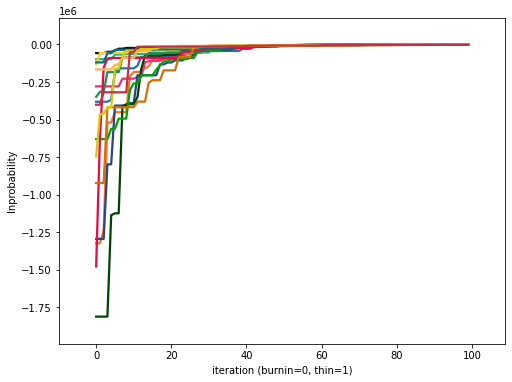

(<autofig.figure.Figure | 1 axes | 16 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [16]:
b.plot(solution='round_1', style='lnprobability', burnin=0, thin=1, show=True)

Here we can see that the burn-in phase is ~50 iterations, as walkers settle to the most probable part of the parameter space. So let's replot, but this time let's remove the burn-in part:

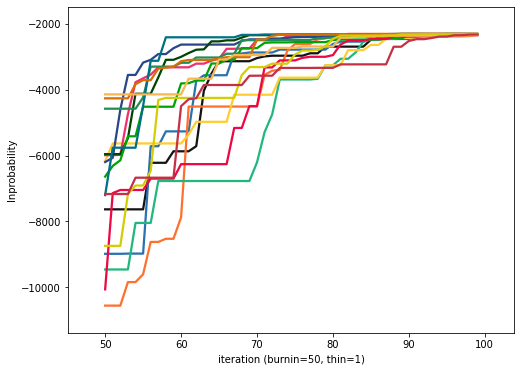

(<autofig.figure.Figure | 1 axes | 16 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [17]:
b.plot(solution='round_1', style='lnprobability', burnin=50, thin=1, show=True)

The solution is still quite clearly converging, but the up side is that all walkers are spaghetti'd together. Let's take at the posterior plot:

(None, <Figure size 849.6x849.6 with 25 Axes>)

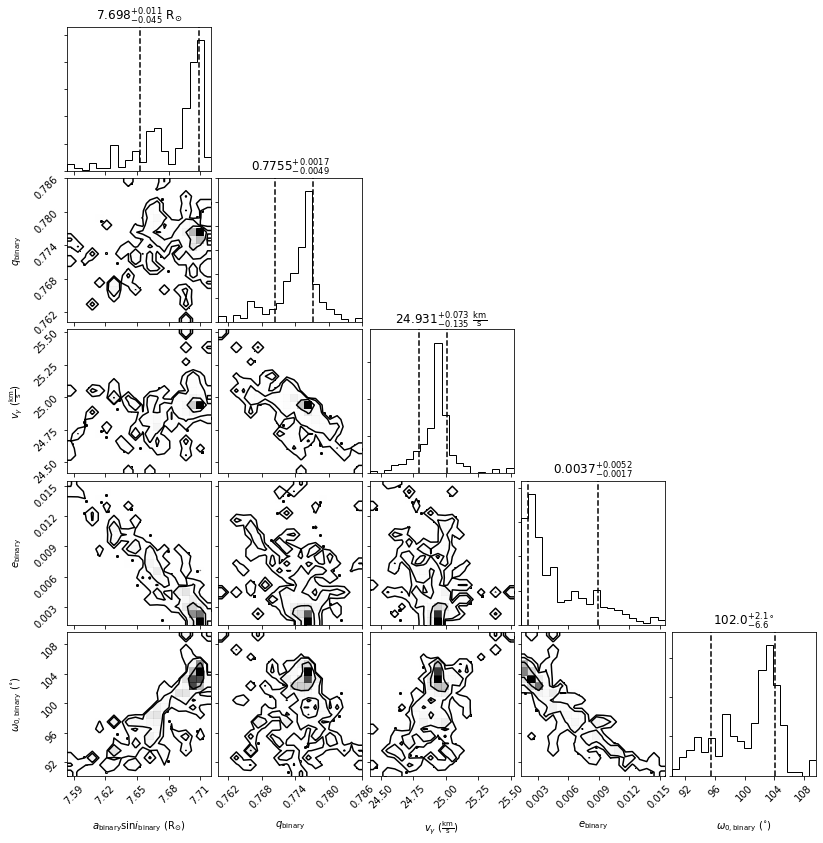

In [18]:
b.plot(solution='round_1', style='corner', burnin=50, thin=1, show=True)

Given that we are computing posteriors and cross-sections for only 50 iterations, the ruggedness should not surprise us; that will get much better with additional iterations. Finally, let's take a look at trace plots:

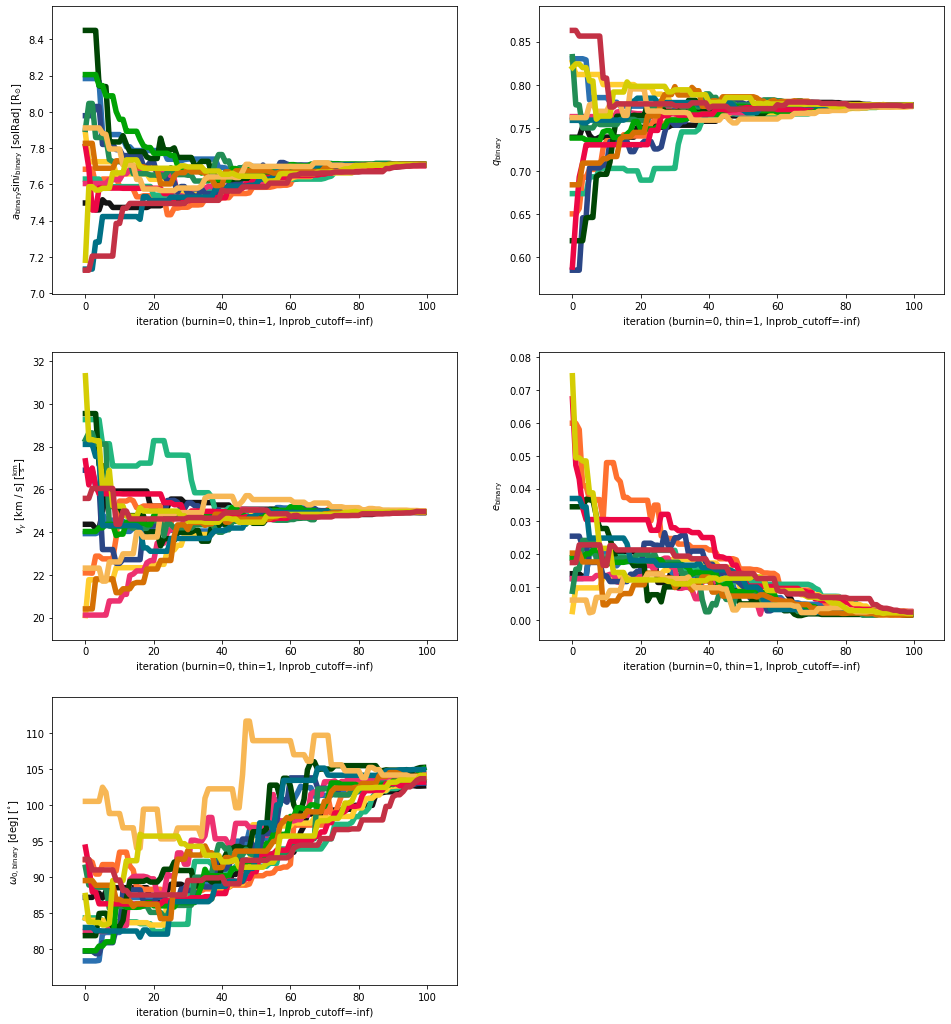

(<autofig.figure.Figure | 5 axes | 80 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [19]:
b.plot(solution='round_1', style='trace', burnin=0, thin=1, show=True)

These plots trace parameter values as a function of iteration. We included the burn-in part here just to demonstrate how walkers form an ensemble as they sample the parameter space. To get the model to converge, we would need an order of magnitude more iterations. Laptops will not cut it anymore, and we will switch to using the cluster in our next tutorial.

Let's save the bundle to have it ready for the next tutorial:

In [20]:
b.save('./data/synthetic/after_initial_sampling.bundle')

'./data/synthetic/after_initial_sampling.bundle'

This concludes the basics of MCMC with PHOEBE! Now you can try it out yourself with these exercises!

# Exercises

**Exercise 1**: generate your own initial state with uniform distributions instead of gaussian distributions. Think about the appropriateness of such a decision.

**Exercise 2**: Initialize a new sampler that uses the initial state generated in Exercise 1, and run it for 100 iterations. Then plot all three types of diagnostic plots. What is the estimated burn-in time? Do posteriors look any better compared to the posteriors we obtained here? Why is that?